# Phase 3: Unsupervised Learning

### In this phase, we apply K-means clustering algorithm to group dataset into clusters. We selected the K-means clustering algorithm for this travel recommendation dataset due to its simplicity, efficiency, and widespread applicability in similar scenarios. K-means is particularly effective when dealing with large datasets, as it scales well with the number of data points. Its ability to partition data into a predefined number of clusters (K) aligns perfectly with our goal of segmenting users, flights, and hotels into distinct groups for targeted recommendations. Moreover, the algorithm's objective of minimizing within-cluster variance is well-suited for identifying cohesive groups based on shared characteristics. K-means provides a strong balance of performance and interpretability, making it a practical choice for our initial exploration and implementation of a travel recommendation system.

## Load libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pickle
import warnings
warnings.filterwarnings("ignore")

## Load cleaned dataset

In [6]:
# load cleaned dataset
merged_df = pd.read_csv('data/merged_df.csv')
cleaned_df = pd.read_csv('data/cleaned_df.csv')

In [7]:
# Define features
features = ['from','price_x', 'time','flightType', 'agency', 'days', 'price_y', 'age', 'gender','company']

## Split dataset into features and target variable

In [8]:
# features
X = cleaned_df[features]

# target variable
y = cleaned_df['to']

## Apply K-Means Clustering

In [100]:
# Apply K-Means Clustering
wcss = []
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

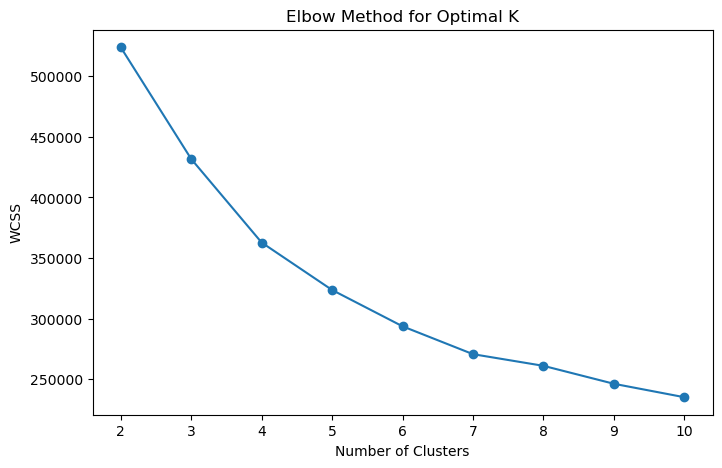

In [101]:
# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

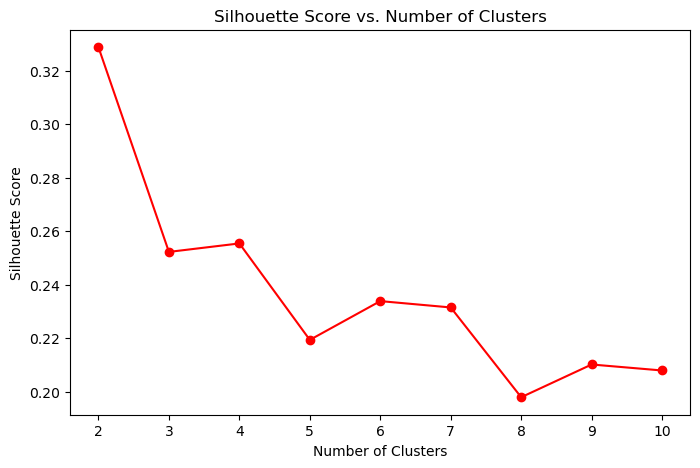

In [102]:
# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='r')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

### The Elbow Method for Optimal K graph clearly indicates an "elbow" at K=4. This suggests a significant reduction in Within-Cluster Sum of Squares (WCSS) up to this point, implying that adding more clusters beyond K=4 yields diminishing returns. The WCSS of 362829.406 at K=4 further substantiates the appropriateness of this choice, representing a good balance between data compression and cluster granularity. Therefore the optimal number of clusters is four.

In [103]:
# Choose optimal K
k_optimal = 4

In [104]:
kmeans_model = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(X)

In [105]:
# Evaluate with Silhouette Score
silhouette_kmeans = silhouette_score(X, kmeans_labels)
print(f'Silhouette Score (K-Means, K={k_optimal}): {silhouette_kmeans:.3f}')

Silhouette Score (K-Means, K=4): 0.255


### While the Silhouette Score peaks at K=2, the score of 0.255 at K=4 is still within a reasonable range, indicating that the clusters are reasonably well-separated. This suggests that while there might be some overlap, the clusters formed at K=4 still possess distinct characteristics.

In [106]:
# Evaluate with Total Within-Cluster Sum of Squares (WCSS)
wcss_kmeans = kmeans_model.inertia_
print(f'Total Within-Cluster Sum of Squares (K-Means, K={k_optimal}): {wcss_kmeans:.3f}')

Total Within-Cluster Sum of Squares (K-Means, K=4): 362829.406


In [107]:
# Evaluate with BCubed Precision and Recall
def bcubed_precision_recall(labels_true, labels_pred):
    n = len(labels_true)
    precision = 0.0
    recall = 0.0

    for i in range(n):
        true_cluster = labels_true[i]
        pred_cluster = labels_pred[i]
        true_indices = set(np.where(labels_true == true_cluster)[0])
        pred_indices = set(np.where(labels_pred == pred_cluster)[0])

        intersection = true_indices.intersection(pred_indices)
        precision += len(intersection) / len(pred_indices)
        recall += len(intersection) / len(true_indices)

    precision /= n
    recall /= n
    return precision, recall

In [108]:
bcubed_precision, bcubed_recall = bcubed_precision_recall(y, kmeans_labels)
print(f'BCubed Precision (K-Means, K={k_optimal}): {bcubed_precision:.3f}')
print(f'BCubed Recall (K-Means, K={k_optimal}): {bcubed_recall:.3f}')

BCubed Precision (K-Means, K=4): 0.146
BCubed Recall (K-Means, K=4): 0.289


### The BCubed Recall of 0.289, though not exceptionally high, indicates that the K-means algorithm at K=4 is successful in grouping a substantial portion of related items together. The BCubed Precision of 0.146 suggests that while there's room for improvement in cluster purity, the algorithm still manages to identify some meaningful associations within the data.

### Considering all three metrics together, K=4 emerges as a viable choice. The elbow method strongly supports it, and while the Silhouette Score and BCubed metrics suggest areas for potential refinement, they do not invalidate the choice. This outcome provides a valuable foundation for the travel recommendation system, offering a segmentation of users, flights, and hotels into four distinct groups.
 
### With K=4, the travel recommendation system can effectively tailor recommendations to four distinct user segments. This segmentation allows for targeted marketing, personalized travel packages, and enhanced user experience, leading to improved customer satisfaction and business outcomes.

In [109]:
# Visualization with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

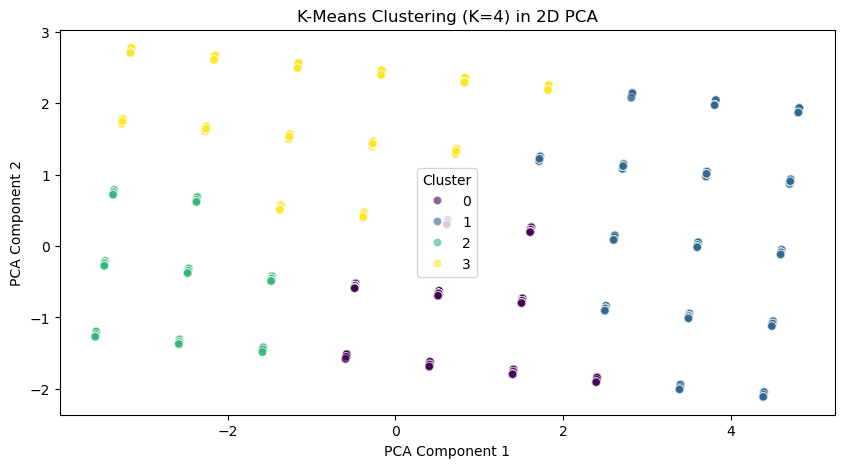

In [110]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', alpha=0.6)
plt.title(f'K-Means Clustering (K={k_optimal}) in 2D PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

### The PCA visualization graph shows that four clusters are well separable.

In [111]:
# Save Kmeans model
pickle.dump(kmeans_model, open('models/kmeans_model.sav', 'wb'))

In [112]:
# save datasets
merged_df['cluster_kmeans'] = kmeans_labels
merged_df.to_csv("data/clustered_dataset.csv", index=False)

## Using K-Means Clustering Algorithm to Make Recommendations

#### The clusters are used to improve recommendations, where we recommend the top destinations, top hotels, average flight price, and average stay cost of users belong to the same cluster of the current user input. The following example shows how we use Random Forest model to predict the destination for a given input data and then we use k-means algorithm to find the cluster of the user based on the input data. After finding the cluster, we calculate the top destinations, top hotels, average flight price, and average stay cost of users in that cluster.

In [12]:
# Load normalization model
to_model = pickle.load(open('models/to_model.sav', 'rb')) 

# load Random Forest model
RF_Model = pickle.load(open('models/RF_Model.sav', 'rb')) 

# load K-Means model
kmeans_model = pickle.load(open('models/kmeans_model.sav', 'rb')) 

In [13]:
# input data
data = X.iloc[3,:]

In [14]:
# Predict the destination using Random Forest Model
predicted_destination = RF_Model.predict(np.array(data).reshape(1, -1))
predicted_destination_label = to_model.inverse_transform(predicted_destination)
print('Predicted Destination: ', predicted_destination_label[0])

Predicted Destination:  Aracaju (SE)


In [15]:
# find cluster of the current input data
predicted_cluster = kmeans_model.predict(np.array(data).reshape(1, -1))

# Make Recommendations

In [16]:
# load clustered dataset
clustered_dataset = pd.read_csv('data/clustered_dataset.csv')

In [17]:
# Fetch similar users in the same cluster
similar_users = clustered_dataset[clustered_dataset['cluster_kmeans'] == predicted_cluster[0]]
top_destinations = similar_users['to'].value_counts().head(2).index.tolist()
top_hotels = similar_users['name_x'].value_counts().head(3).index.tolist()

In [18]:
# add the predicted destination to the top destinations 
if predicted_destination_label[0] not in top_destinations:
    top_destinations.insert(0, predicted_destination_label[0])

In [19]:
recommendation = f"""
Based on your input, we recommend the following:
- Top Destinations: {', '.join(top_destinations)}
- Recommended Hotels: {', '.join(top_hotels)}
- Average Flight Price: ${similar_users['price_x'].mean():.2f}
- Average Stay Cost: ${similar_users['total'].mean():.2f}
"""

In [20]:
print(recommendation)


Based on your input, we recommend the following:
- Top Destinations: Aracaju (SE), Florianopolis (SC), Campo Grande (MS)
- Recommended Hotels: Hotel K, Hotel AF, Hotel CB
- Average Flight Price: $1009.21
- Average Stay Cost: $510.16



In [21]:
print('done')

done
